In [1]:
import os, sys, re
import numpy as np
import pandas as pd
import hashlib
import random
import math
import json
from random import sample
from tqdm import tqdm
import IPython
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

### Prepare data and compute features

In [2]:
words_1000 = [] 
with open('1000-midlong', 'r') as thousend_words:
    for word in thousend_words:
        words_1000.append(word.strip())

In [38]:
#keywords = ['percent', 'world', 'today', 'people', 'last', 'another', 'change', 'should', 'sort', 'find', 'after', 'fact']
keywords = ['people', 'because', 'think', 'world'] #set 1
#keywords = ['something', 'different', 'actually', 'important'] #set 2
#keywords = ['another', 'percent', 'problem', 'technology'] #set 3
#keywords = ['information', 'experience', 'government', 'computer'] 
#keywords = ['years', 'little', 'through', 'together'] # set 4

In [4]:
possible_non_keywords = list(set(words_1000) - set(keywords))

For the non keywords, we sample randomly 600 words from the database.

In [5]:
non_keywords = sample(possible_non_keywords, k=600)

Select TED talks on which we will test our models

In [11]:
def get_test_ted_talks(path2_ted_speakers='"../../Datasets/TEDLIUM_release-3/data/json/', nb_ted_talks=100):  
    ted_speakers = [name for name in os.listdir(path2_ted_speakers) if not name.startswith('.') and os.path.isdir(os.path.join(path2_ted_speakers, name))]
    test_ted_talks = sample(ted_speakers, k=nb_ted_talks)
    return test_ted_talks 

In [4]:
#test_ted_talks = get_test_ted_talks(path2_ted_speakers='/aimlx/Datasets/TEDLIUM_release-3/data/json/', nb_ted_talks=50)
test_ted_talks = np.load('test_ted_talks_50.npy', allow_pickle=True)

In [7]:
path = os.path.abspath("/aimlx/Datasets/TEDLIUM_release-3/data/1000_kws_db")
filenames = []

for w in keywords + non_keywords:
    current_path = os.path.join(path, w[0], w) 
    for _, _, files in os.walk(current_path):
        for file in files:
            if all(test_ted_talk not in file for test_ted_talk in test_ted_talks):
                filenames.append(os.path.join(current_path, file))

We load the **1 second long** *.wav* file which contains the keyword surrounded with context and compute **40 MFCC features**. 

In [5]:
num_features = 40
xdim = 98

In [9]:
from preprocessing import compute_mfcc

In [10]:
fs, sig = wav.read(filenames[10])
xdim, _ = compute_mfcc(sig, fs, threshold=1.0, is_kw=True, num_features=40, add_noise=False)[0].shape

**We use a hashing function to perform the split**

In [12]:
kw = filenames[0].split('/')[-2]
base_name = kw + '-' + os.path.basename(filenames[0]).replace('_', '-', 1)
hash_name = re.sub(r'_.*$', '', base_name).encode('utf-8')

In [13]:
hash_name

b'people-DavidBlaine-2009P'

**Split and compute features for the training, testing and validation sets**

In [14]:
from preprocessing import generate_sets

training, validation, testing = generate_sets(filenames, keywords, frame_size=1.0, n_mfcc=40, validation_percentage=15, 
                                              testing_percentage=5, add_noise=True, manipulate_pitch=True, add_volume=True)

100%|██████████| 877713/877713 [53:41<00:00, 272.47it/s]


**Shape features in correct format or models to train on**

In [16]:
from preprocessing import get_X_y
from keras.utils import to_categorical

In [17]:
X_train, y_train = get_X_y(training, xdim=xdim, num_features=num_features)
X_validation, y_validation = get_X_y(validation, xdim=xdim, num_features=num_features)
y_train, y_validation = to_categorical(y_train), to_categorical(y_validation)

### Train model

**We defined 2 architectures: a deep CNN and a Residual network**

In [18]:
import keras

In [54]:
import importlib
import models
importlib.reload(models)

<module 'models' from '/aimlx/kws/e2e_kws/models.py'>

In [19]:
from models import *

In [41]:
#model = dnn_model(len(keywords), xdim=xdim, num_features=num_features)
#model = res_net(len(keywords), xdim=xdim, num_features=num_features)
model = cnn_parada(len(keywords), xdim=xdim, num_features=num_features)
#model = baseline_dnn(len(keywords), xdim=xdim, num_features=num_features)

In [35]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 79, 33, 64)        10304     
_________________________________________________________________
batch_normalization_3 (Batch (None, 79, 33, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 79, 11, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 70, 8, 64)         163904    
_________________________________________________________________
batch_normalization_4 (Batch (None, 70, 8, 64)         256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 70, 2, 64)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8960)              0         
__________

In [42]:
model.fit(X_train, y_train, batch_size=200, epochs=3, verbose=1, validation_data=(X_validation, y_validation))

Train on 813619 samples, validate on 152839 samples
Epoch 1/3
813619/813619 [==============================] - 162s 199us/step - loss: 0.3734 - acc: 0.8846 - val_loss: 0.3531 - val_acc: 0.8848
Epoch 2/3
813619/813619 [==============================] - 161s 198us/step - loss: 0.2313 - acc: 0.9221 - val_loss: 0.2577 - val_acc: 0.9171
Epoch 3/3
813619/813619 [==============================] - 161s 198us/step - loss: 0.1929 - acc: 0.9329 - val_loss: 0.2722 - val_acc: 0.9152


In [47]:
model.fit(X_train, y_train, batch_size=200, epochs=1, verbose=1, validation_data=(X_validation, y_validation))

Train on 813619 samples, validate on 152839 samples
Epoch 1/1
813619/813619 [==============================] - 163s 200us/step - loss: 0.1614 - acc: 0.9416 - val_loss: 0.2612 - val_acc: 0.9189


In [32]:
model.fit(X_train, y_train, batch_size=200, epochs=1, verbose=1, validation_data=(X_validation, y_validation))

Train on 813619 samples, validate on 152839 samples
Epoch 1/1
813619/813619 [==============================] - 162s 200us/step - loss: 0.1315 - acc: 0.9505 - val_loss: 0.3594 - val_acc: 0.9098


In [51]:
model.save('set1_models/cnn_parada_set1_4_epochs.h5')

In [95]:
model = keras.models.load_model('set2_models/dnn_set2_4_epochs.h5')

In [10]:
testing = np.load('set3_results/testing_set3.npy', allow_pickle=True)
test_ted_talks = np.load('test_ted_talks_50.npy', allow_pickle=True)

### Evaluate model

**Single keywords with context**

In [23]:
from sklearn.metrics import accuracy_score

In [48]:
X_test, y_test = get_X_y(testing, xdim=xdim, num_features=num_features)
y_pred = model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1).reshape(-1,1)

49951/49951 [==============================] - 7s 144us/step


In [44]:
def accuracy_per_label(y_true, y_pred, label):
    y_true_label = y_true[y_true == label]
    y_pred = y_pred[y_true == label]
    n_samples = len(y_pred)
    return n_samples, accuracy_score(y_true_label, y_pred)

In [49]:
accuracies_per_label = []

for i in range(len(keywords) + 1):
    n, acc = accuracy_per_label(y_test, y_pred, label=i)
    if i < len(keywords):
        accuracies_per_label.append((n, acc, keywords[i]))
    else:
        accuracies_per_label.append((n, acc, 'non_keyword'))

In [46]:
accuracies_per_label = sorted(accuracies_per_label, key=lambda x: x[1], reverse=True)
accuracies_per_label

[(41011, 0.9691790007558948, 'non_keyword'),
 (3364, 0.8647443519619501, 'people'),
 (2164, 0.661275415896488, 'because'),
 (1704, 0.6068075117370892, 'world'),
 (1708, 0.38583138173302106, 'think')]

In [50]:
accuracies_per_label = sorted(accuracies_per_label, key=lambda x: x[1], reverse=True)
accuracies_per_label

[(41011, 0.9644241788788374, 'non_keyword'),
 (3364, 0.8156956004756243, 'people'),
 (1704, 0.704225352112676, 'world'),
 (2164, 0.6848428835489834, 'because'),
 (1708, 0.5971896955503513, 'think')]

**100 Test TED talks of ~ 30 minutes each**

In [6]:
from evaluate import prepare_test_ted_talks
from postprocessing import probability_smoothing, reduce_false_alarms

In [7]:
shift = 0.1
window_dur = 1.0
w_smooth = 3

In [40]:
test_frames, test_gt_vector, T = prepare_test_ted_talks(test_ted_talks, shift=shift, window_dur=window_dur, xdim=xdim, num_features=num_features, keywords=keywords,
                                                     path2wav='/aimlx/Datasets/TEDLIUM_release-3/data/wav', path2json='/aimlx/Datasets/TEDLIUM_release-3/data/final_json')

100%|██████████| 50/50 [09:27<00:00, 11.36s/it]


In [63]:
y_pred = model.predict(test_frames, verbose=1)
y_pred_smoothed = probability_smoothing(y_pred, w_smooth=3)
y_pred_modified = reduce_false_alarms(y_pred)

260394/260394 [==============================] - 41s 157us/step


100%|██████████| 260392/260392 [00:16<00:00, 15976.44it/s]


In [64]:
y_prediction = np.argmax(y_pred, axis=1)
sum(y_prediction == test_gt_vector)/len(y_prediction)

0.9675798981543353

In [65]:
y_prediction_smoothed = np.argmax(y_pred_smoothed, axis=1)
sum(y_prediction_smoothed == test_gt_vector)/len(y_prediction_smoothed)

0.9768312633931657

In [66]:
y_prediction_modified = np.argmax(y_pred_modified, axis=1)
sum(y_prediction_modified == test_gt_vector)/len(y_prediction_modified)

0.9803605305805817

In [67]:
y_pred_smoothed_post = probability_smoothing(y_pred_modified, w_smooth=3)
y_prediction_smoothed_post = np.argmax(y_pred_smoothed_post, axis=1) 
sum(y_prediction_smoothed_post == test_gt_vector)/len(y_prediction_smoothed_post)

100%|██████████| 260394/260394 [00:11<00:00, 22407.73it/s]


0.9796577494105086

In [68]:
y_pred_smoothed_pre = reduce_false_alarms(y_pred_smoothed)
y_prediction_smoothed_pre = np.argmax(y_pred_smoothed_pre, axis=1)
sum( y_prediction_smoothed_pre == test_gt_vector)/len(y_prediction_smoothed_pre)

100%|██████████| 260392/260392 [00:03<00:00, 82340.01it/s]


0.9785440524743274

**FOM results**

In [69]:
from postprocessing import segment_integration, fom_result

In [ ]:
seg_preds, seg_scores, seg_gt = segment_integration(y_prediction_smoothed_post, np.max(y_pred_smoothed_post, axis=1),
                                                    test_gt_vector, non_keyword_label=len(keywords), segment_size=5, undefined_label=-1)

In [135]:
df_results = pd.DataFrame(columns=['KeyWord', '#Hits', '#FA\'s', '#Actual', 'FOM', 'Recall', 'Precision'])
for i in range(len(keywords)):
    hits, false_alarms, nb_TP, fom = fom_result(seg_preds, seg_scores, seg_gt, keyword_label=i, window_dur=1.0, shift=0.1, segment_size=5, T=T)
    df_results = df_results.append({'KeyWord': keywords[i], '#Hits': hits, '#FA\'s': false_alarms, '#Actual': nb_TP, 'FOM': round(fom, 2), 
                                    'Recall': round(hits/nb_TP, 2), 'Precision': round(hits/(hits+false_alarms), 2)},
                                   ignore_index=True)

In [136]:
df_results

,KeyWord,#Hits,#FA's,#Actual,FOM,Recall,Precision
0,something,56,59,89,29.15,0.63,0.49
1,different,69,110,93,58.26,0.74,0.39
2,actually,103,77,154,42.51,0.67,0.57
3,important,45,115,57,69.91,0.79,0.28


In [94]:
df_results

,KeyWord,#Hits,#FA's,#Actual,FOM,Recall,Precision
0,something,69,103,89,39.936522,0.78,0.40
1,different,53,27,93,6.984207,0.57,0.66
2,actually,59,18,154,3.198505,0.38,0.77
3,important,43,36,57,14.674373,0.75,0.54


In [96]:
df_results

,KeyWord,#Hits,#FA's,#Actual,FOM,Recall
0,another,21,49,38,6.386369,0.55
1,percent,19,13,30,2.320730,0.63
2,problem,6,4,13,0.612061,0.46
3,technology,42,50,64,6.511511,0.66


In [122]:
df_results

,KeyWord,#Hits,#FA's,#Actual,FOM
0,information,11,90,24,13.553414
1,experience,4,24,23,1.167333
2,government,4,20,22,1.361209
3,computer,5,8,19,1.304389


In [23]:
df_results

,KeyWord,#Hits,#FA's,#Actual,FOM
0,something,60,153,89,21.876342
1,different,70,233,95,17.708499
2,actually,109,100,160,29.701338
3,important,52,145,60,32.291437


In [33]:
df_results

,KeyWord,#Hits,#FA's,#Actual,FOM
0,something,40,21,89,5.012370
1,different,50,110,95,23.499483
2,actually,98,104,160,27.499762
3,important,22,18,60,2.943027


In [22]:
df_results

,KeyWord,#Hits,#FA's,#Actual,FOM
0,another,28,48,62,8.527616
1,percent,24,57,43,10.182321
2,problem,28,68,63,17.390987
3,technology,11,22,22,6.101970


In [32]:
df_results

,KeyWord,#Hits,#FA's,#Actual,FOM
0,another,38,86,62,23.484256
1,percent,28,54,43,11.743290
2,problem,20,23,63,4.704254
3,technology,12,21,22,6.477476


**Plot results**

In [64]:
index_neg = (test_gt_vector == -1)
gt_kw = abs(test_gt_vector - len(keywords))
gt_kw[index_neg] = -1
#pred_kw = abs(y_prediction_modified - len(keywords))
#pred_kw[pred_kw > 0] = 1
gt_fixed = gt_kw
gt_fixed[gt_fixed > 0] = 1 

In [65]:
nb_frames = 200
gen = [nb_frames*i for i in range(1, int(len(test_gt_vector)/nb_frames) + 1)]
gen = iter(gen)
end = 0
speech_seg_size = window_dur + (nb_frames - 1)*shift
end_speech_seg = 0

In [ ]:
exists = True
while exists:
    try:
        start = end
        end = next(gen)

        start_speech_seg = end_speech_seg
        end_speech_seg = start_speech_seg + speech_seg_size

        plt.figure(figsize=(12, 10))
        plt.plot(gt_fixed[start:end], label='ground truth')
        #plt.plot(pred_kw[start:end], label='prediction')

        for i in range(len(keywords)):
            plt.plot(y_pred_smoothed_pre[start:end,i], label=keywords[i])

        plt.plot([0.5] * nb_frames , color='black')
        plt.legend(loc="lower right")
        plt.ylabel('probabilty')
        plt.xlabel('frame index')
        title = 'Predictions for Speech Segment: ' + str(round(start_speech_seg, 3)) + 's - ' + str(round(end_speech_seg,3)) + 's'     
        plt.title(title)
        plt.show()
        #plt.savefig('test_ted_talk_images/' + title + '.png')
    except:
        exists = False


In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [41]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues', vmin=0, vmax=1000)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

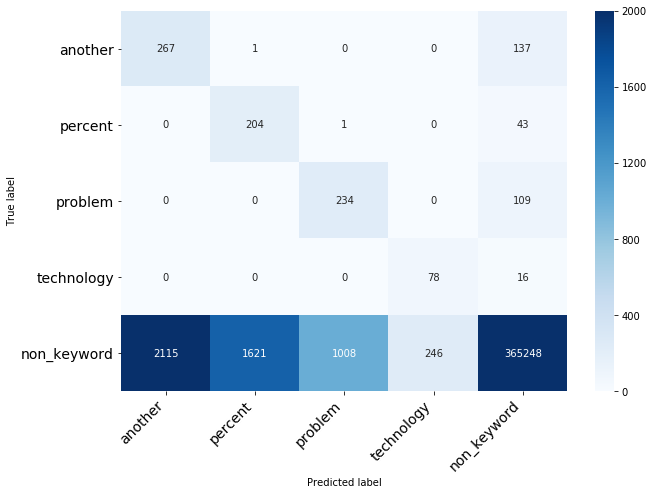

In [38]:
cm = confusion_matrix(y_true=test_gt_vector, y_pred=y_prediction)
#cm = cm[1:,1:]
_  = print_confusion_matrix(cm, keywords + ['non_keyword'])

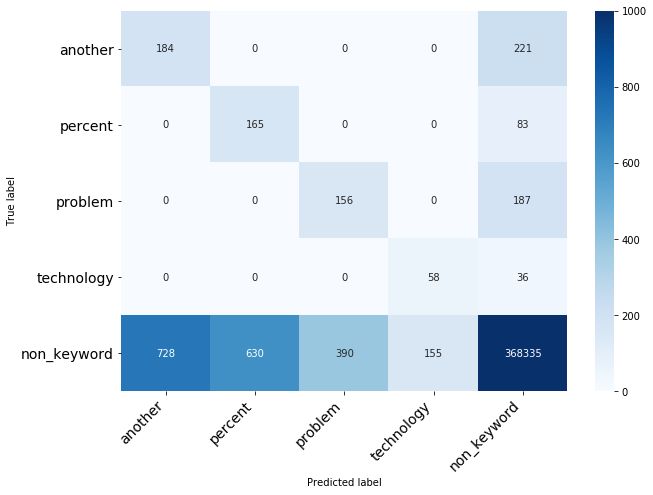

In [43]:
cm_smoothed = confusion_matrix(y_true=test_gt_vector, y_pred=y_prediction_smoothed_post)
#cm_smoothed = cm_smoothed[1:,1:]
_  = print_confusion_matrix(cm_smoothed, keywords + ['non_keyword'])

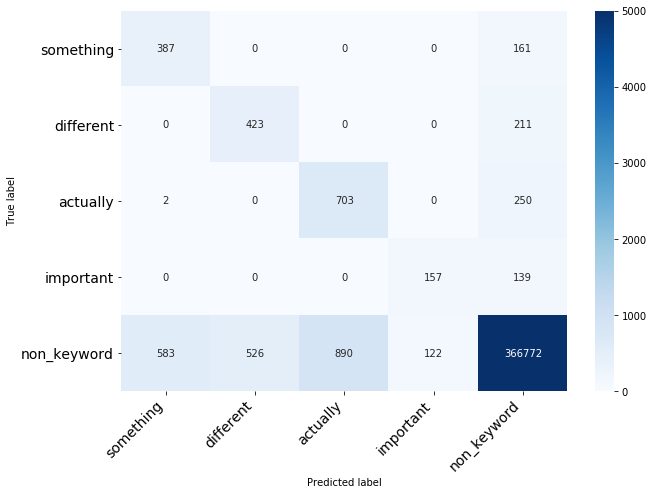

In [42]:
cm_modif = confusion_matrix(y_true=test_gt_vector, y_pred=y_prediction_modified)
cm_modif = cm_modif[1:,1:]
_  = print_confusion_matrix(cm_modif, keywords + ['non_keyword'])

**Get path to all TED talks**

In [42]:
from preprocessing import which_set
from postprocessing import create_file, extract_sentence

In [321]:
path2wav_train = os.path.abspath("../../Datasets/TEDLIUM_release1/train/wav/")
path2wav_test = os.path.abspath("../../Datasets/TEDLIUM_release1/test/wav/")
path2wav_dev = os.path.abspath("../../Datasets/TEDLIUM_release1/dev/wav/")

path2ted_talks = []

for _, _, files in os.walk(path2wav_train):
    for file in files:
        path2ted_talks.append(os.path.join(path2wav_train, file))
        
for _, _, files in os.walk(path2wav_test):
    for file in files:
        path2ted_talks.append(os.path.join(path2wav_test, file))
        
for _, _, files in os.walk(path2wav_dev):
    for file in files:
        path2ted_talks.append(os.path.join(path2wav_dev, file))

In [30]:
test_ted_talks_people = []
for file in tqdm(filenames):
    grp = which_set(file, validation_percentage=10, testing_percentage=10)
    if grp is 'testing':
        if 'people' in file:
            ted_talk = re.sub(r'_.*$', '', os.path.basename(file).replace('_', '-', 1)).replace('-', '_')
            path2ted_talk = list(filter(lambda x: ted_talk in x, path2ted_talks))
            test_ted_talks_people.extend(path2ted_talk)
test_ted_talks_people = list(set(test_ted_talks_people))

100%|██████████| 230882/230882 [00:02<00:00, 97693.53it/s] 


In [43]:
test_files = []
for file in filenames:
    grp = which_set(file, validation_percentage=10, testing_percentage=10)
    if grp is 'testing':
        if any(kw in file for kw in keywords):
            test_files.append(file)

In [44]:
test_files_iterator = iter(test_files)

In [45]:
from postprocessing import create_file, extract_sentence

In [ ]:
file_partition = create_file()
fs, sentence, y_test = extract_sentence(path2wav_file=random.sample(test_files,k=1)[0], path2dataset='/aimlx/Datasets/TEDLIUM_release1/', keywords=keywords,
                                        file_partition=file_partition, duration=5, shift=0.1, percentage_kw=1.0)

IPython.display.Audio(sentence, rate=fs)

In [89]:
y_test

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0,
       0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

100%|██████████| 44/44 [00:00<00:00, 414.39it/s]

44/44 [==============================] - 0s 180us/step


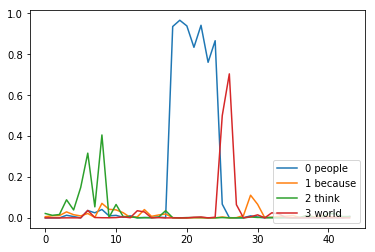

In [90]:
frames = compute_mfcc_frames(sentence, fs, xdim, shift=0.1, num_features=40)
y_pred = model.predict(frames, verbose=1)
plt.plot(y_pred[:,0], label='0 ' + keywords[0])
plt.plot(y_pred[:,1], label='1 ' + keywords[1])
plt.plot(y_pred[:,2], label='2 ' + keywords[2])
plt.plot(y_pred[:,3], label='3 ' + keywords[3])
#plt.plot(y_pred[:,4], label='4 ' + keywords[4])
plt.legend(loc="lower right")

In [329]:
np.argmax(y_pred, axis=1)

array([5, 5, 5, 5, 1, 5, 5, 5, 4, 4, 4, 5, 5, 5, 5, 5, 5, 1, 1])

In [ ]:
# precision recall curve
# temp = label_binarize(y_test, classes=range(len(keywords) + 1))
# precision, recall, _ = precision_recall_curve(temp[:, 3],y_pred[:, 3])
# plt.plot(recall, precision, lw=2)
# plt.xlabel("recall")
# plt.ylabel("precision")
# plt.title("precision vs. recall curve")
# plt.show()

In [53]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from scipy import interp
from sklearn.preprocessing import label_binarize

**ROC AUC**

100%|██████████| 1123/1123 [17:47<00:00,  1.05it/s]
/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


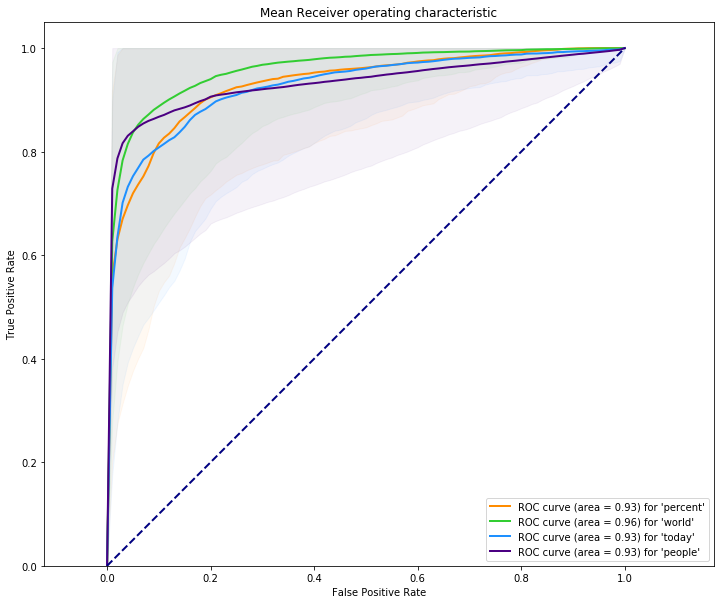

In [138]:
#tprs = []
tprs = dict()
base_fpr = np.linspace(0, 1, 101)
auc_scores = []
file_partition = create_file()
plt.figure(figsize=(12, 10))
error_files = []
classes = range(len(keywords) + 1)
fpr, tpr, auc_scores = dict(), dict(), dict()
colors = ['darkorange', 'limegreen', 'dodgerblue', 'indigo', 'red', 'dimgray']

#test_files[:5] + test_files[-5:] + test_files[100:105] + test_files[415:420]

for file in tqdm(test_files, position=0, leave=True):
    try:
        fs, sentence, y_test = extract_sentence(path2wav_file=file, path2dataset='/aimlx/Datasets/TEDLIUM_release1/',
                                                file_partition=file_partition, duration=5, shift=0.01, percentage_kw=1.0)
        
        keyword = file.split('/')[-2]
        idx = keywords.index(keyword)
        
        y_test = label_binarize(y_test, classes=classes)
        frames = compute_mfcc_frames(sentence, fs, shift=0.01, num_features=40)
        y_pred = model.predict_proba(frames)

        fpr, tpr, _ = roc_curve(y_test[:, idx], y_pred[:, idx])
        auc_score = auc(fpr, tpr)
        if idx not in auc_scores:
            #fpr[idx] = [fpr]
            #tpr[idx] = [tpr]
            auc_scores[idx] = [auc_score]
        else:
            #fpr[idx].append(fpr)
            #tpr[idx].append(tpr)
            auc_scores[idx].append(auc_score)           
            
        #plt.plot(fpr, tpr, 'darkorange', alpha=0.05)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        if idx not in tprs:
            tprs[idx] = [tpr]
        else:
            tprs[idx].append(tpr)
        
    except IndexError as error:
        error_files.append(file)
        
for idx in tprs.keys():
    tprs[idx] = np.array(tprs[idx])
    mean_tprs = tprs[idx].mean(axis=0)
    std = tprs[idx].std(axis=0)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
    plt.plot(base_fpr, mean_tprs, colors[idx], lw=2, label='ROC curve (area = %0.2f) for \'%s\'' % (np.mean(np.array(auc_scores[idx])), keywords[idx])) 
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color=colors[idx], alpha=0.05)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1.05])
plt.ylim([0, 1.05])
plt.title('Mean Receiver operating characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.axes().set_aspect('equal', 'datalim')
plt.show()

**Precision-Recall curve**

ROC curves can present an overly optimistic view of an algorithm’s performance if there is a large skew in the class distribution. Precision-Recall (PR) curves, often used in Information Retrieval , have been cited as an alternative to ROC curves for tasks with a large skew in the class distribution.

Davis and Goadrich in this [paper](http://ftp.cs.wisc.edu/machine-learning/shavlik-group/davis.icml06.pdf) propose that Precision-Recall (PR) curves will be more informative than ROC when dealing with highly skewed datasets. The PR curves plot precision vs. recall (FPR). Because Precision is directly influenced by class imbalance so the Precision-recall curves are better to highlight differences between models for highly imbalanced data sets. When you compare different models with imbalanced settings, the area under the Precision-Recall curve will be more sensitive than the area under the ROC curve